# Fahrmodell trainieren

In diesem Notebook werden wir unser Fahrmodell für das selbständige Fahren trainieren.

Du wirst hier viele Gemeinsamkeiten zur Bilderkennung von letzter Woche sehen, aber auch einige Unterschiede.

Überlege dir nochmals, was wir als Input benötigen und was unser Output *"Label"* ist. Also was das Modell vorhersagen soll.

⚠️ **In diesem Notebook befinden Aufgaben. Ihr müsst die gelösten Aufgaben eurem Coach abgeben, damit sie bewertet werden.** ⚠️

Zu Beginn importieren wir einige Packages und testen ob eine GPU zur verfügung steht:

In [1]:
from pathlib import Path
import json
from collections import OrderedDict
import random

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelSummary
from PIL import Image
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from aic.drive.model import LightningDriveModel
from aic.logger import DictLogger
from aic.runs import create_run_dir
from aic.helpers import disable_warnings
disable_warnings()

print(f'GPU (Cuda) is available: {torch.cuda.is_available()}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.mps.is_available() else torch.device('cpu')
print(f'Using device: {device}')

GPU (Cuda) is available: True
Using device: cuda


## Daten laden

Die aufgenommen Fahrdaten werden eingelesen

### Daten laden
Um die Daten laden zu können benötigen wir einige Hilfsfunktionen. Die erste ist eine Funktion um alle Bilder im Ordner zu finden und als Pfade zurückzugeben:

In [2]:
def get_image_paths(path: Path) -> list:
    return list(sorted(path.glob('**/*.jpg')))

### 📝 Aufgabe 3.2
Die nächste Funktion liest die Daten für Lenkung und Geschwindigkeit aus dem zum Bild gehörenden JSON-File heraus. Erstelle eine Funktion, die für jedes Bild `angle` und `speed` zurückgibt.

- Als Eingabe erhält die Funktion einen Bild-Pfad, z.B. `recordings/01/01.jpg`
- Die JSON-Datei hat den gleichen Pfad, einfach mit der Endung `.json` anstatt `.jpg`
- Die Funktion gibt ein Tuple `(angle, speed)` mit den Werten als `float` zurück.

In [3]:
# 📝 Programmiere die Funktion:
def read_data_from_json(image_path: str | Path) -> tuple[float, float]:
    path = Path(image_path).with_suffix('.json')
    with open(path, 'r') as f:
        data = json.load(f)
    steering_angle = float(data['angle'])
    throttle = float(data['speed'])
    return steering_angle, throttle

Um deinen Code zu überprüfen kannst du folgende Tests ausführen:

In [4]:
# Arrange
import tempfile
p = Path(tempfile.gettempdir()) / 'test1-3'; p.mkdir(exist_ok=True)
img_path = p / 'test_01.jpg'
img_path.touch()
json_path = p / 'test_01.json'
json_path.write_text('{"angle": 17.805982737, "speed": 31}')

# Test
ret = read_data_from_json(str(img_path))
assert isinstance(ret, tuple), f'Die Funktion sollte ein Tuple zurückgeben, aber gibt {type(ret)} zurück'
assert len(ret) == 2, f'Das Tuple sollte genau 2 Elemente enthalten, aber enthält {len(ret)} Elemente'
assert all(isinstance(x, float) for x in ret), f'Die Elemente des Tuples sollten Zahlen von Typ float sein'
assert ret == (17.805982737, 31), f'Die Funktion sollte (17.805982737, 31.0) zurückgeben, gibt aber {ret} zurück'

# Cleanup
img_path.unlink()
print('Die Funktion funktioniert 👍')

Die Funktion funktioniert 👍


Nun können wir die Bilder laden.

In [8]:
image_dir_path = Path('../data/')

# Sollte der Pfad nicht existieren, wird hier eine Fehlermeldung ausgegeben
if not image_dir_path.exists():
    raise Exception(f"Fehler: Der Pfad {image_dir_path} existiert nicht 🛑")
else:
    print(f"Der Pfad {image_dir_path} wurde gefunden 👍")

Der Pfad ../data wurde gefunden 👍


Es wurden 12933 Bilder gefunden
Beispielbild: ../data/16_00000042.jpg
Größe des Bildes (BxH): (320, 240)


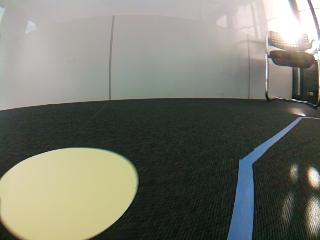

Geschwindigkeit 25.00, Lenkung: 14.00


In [9]:
# alle Bildpfade laden
image_paths = get_image_paths(image_dir_path)
assert len(image_paths) > 0, "Keine Bilder gefunden"
print(f"Es wurden {len(image_paths)} Bilder gefunden")

# der erste Pfad auswählen und ausgeben (wenn du einen anderen willst, ändere den Index)
some_image_path = image_paths[42]
print('Beispielbild:', some_image_path)

# Bild laden und anzeigen
img = Image.open(some_image_path)
print(f"Größe des Bildes (BxH): {img.size}")
display(img)

# Dazugehörige Daten für Lenkung und Geschwindigkeit ausgeben
angle, speed = read_data_from_json(some_image_path)
print(f"Geschwindigkeit {speed:.2f}, Lenkung: {angle:.2f}")

### Daten betrachten

Wir können uns nun die Daten betrachten, auf welche wir Trainieren wollen. In diesem Schritt können wir schädliche Daten erkennen und entfernen

*Wichtig*: Wenn du hier unlogische Daten hast, dann entferne diese Abschnitte aus den Trainingsdaten. Beispiel hierfür sind:
- Minus-Geschwindigkeit (unser Modell soll nie rückwärts fahren)
- Längere Abschnitte mit Null-Geschwindigkeit (unser Fahrmodell soll nie anhalten)
- Wenn der Durchschnitt der Lenkung um 0 herum ist, heisst das, dass du vermutlich gleichviel Links- wie Rechtskurven in den Daten hast

**Dein Modell kann nur so gut sein wie die Daten mit denen du es trainiertes!**

Wir können uns alle Fahrdaten als Diagramm betrachten und einige Kennzahlen ermitteln.

*Hineweis: Das auslesen der Daten kann eine Weile dauern.*

In [10]:
%%time
from multiprocessing.pool import ThreadPool
with ThreadPool(20) as pool:
  vehicle_data = np.array(pool.map(read_data_from_json, image_paths))
all_angles = vehicle_data[:,0]
all_speeds = vehicle_data[:,1]

print(f"Kennzahlen zu Lenkung: min={all_angles.min():.2f}, max: {all_angles.max():.2f}, Durchschnitt: {all_angles.mean():.2f}")
print(f"Kennzahlen zu Geschwindigkeit: min={all_speeds.min():.2f}, max: {all_speeds.max():.2f}, Durchschnitt: {all_speeds.mean():.2f}")

Kennzahlen zu Lenkung: min=-34.72, max: 35.56, Durchschnitt: -0.24
Kennzahlen zu Geschwindigkeit: min=25.00, max: 25.00, Durchschnitt: 25.00
CPU times: user 585 ms, sys: 393 ms, total: 978 ms
Wall time: 650 ms


Als nächstes plotten wir den Winkel und die Geschwindigkeit über die Zeit:

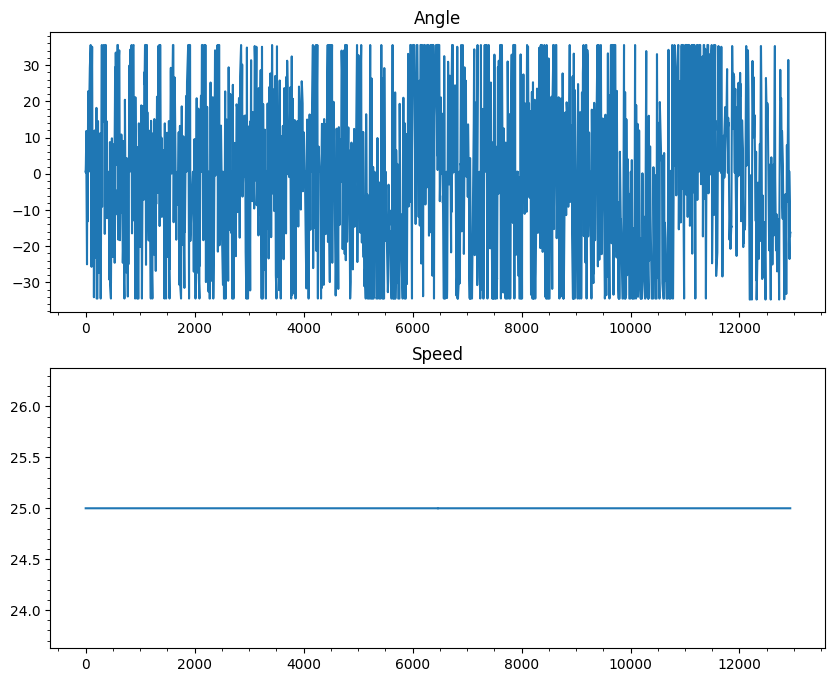

In [11]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
fig, (ax1, ax2) = plt.subplots(2,figsize=(10, 8))
ax1.plot(all_angles)
ax1.set_title("Angle")
ax1.minorticks_on()
ax2.plot(all_speeds)
ax2.set_title("Speed")
ax2.minorticks_on()

### Data Augmentation
Beim trainieren von Machine-Learning-Modellen sind die Trainingsdaten oft der Hauptfaktor, ob das Modell das gewünschte Wissen lernt oder nicht. Gleichzeitig ist das sammeln von Daten Zeitaufwändig. Um aus einer begrenzten Menge Daten mehr zu machen, verwenden wir Augmentation. Augmentation heisst "Erweiterung". Ziel ist es dabei unsere Bilder leicht zu verändern, um so mehr Trainingsdaten zu erhalten, ohne tatsächlich mehr Bilder aufzunehmen. Augmentation bei Bildern kann z.B. die Helligkeit und Kontrast verändern, oder das Bild leicht drehen oder vergrössern.

All das hilft, dass unsere AI nicht die Trainingsdaten auswendig lernt (Overfitting), sondern lernt zu "generalisieren". Also anstatt, dass die AI lernt *"wenn der 7 Pixel von Links Blau ist..."*, soll die AI lernen *"wenn ich eine Form erkenne, die wie eine Linkskurve aussieht..."*.

Du kannst [hier](https://www.arocom.de/fachbegriffe/kuenstliche-intelligenz/datenaugmentierung) mehr über Data Augmentation nachlesen und dir [hier](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py) die Data Augmentation Funktionen von PyTorch ansehen. **Eine schöne Übersicht** über die in PyTorch enthaltenen Augmentation-Funktionen findest du [hier](https://pytorch.org/vision/2.0/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py).

Für erste werden wir mit der Helligkeit und Farbe im Bild augmentieren, damit unser Modell auch zurechtkommt, wenn die Lichtverhältnisse leicht anders sind als im Training. Später (siehe zusätzliche Aufgaben) kannst du auch eigene Augmentations vornehmen.

In [12]:
from torchvision.transforms import v2

transformer = v2.Compose(
    [
        # Helligkeit, Kontrast, Sättigung und Farbton werden zufällig bis zum angegeben Wert geändert
        # Du kannst die Werte anpassen, wenn du willst (siehe Zusatzaufgabe)
        v2.ColorJitter(
            brightness=0.5,
            saturation=0.2,
            hue=0.1,
        ),
        # v2.Pad(padding=10),
        # Platz für weitere Transformationen (siehe Zusatzaufgabe)
    ]
)

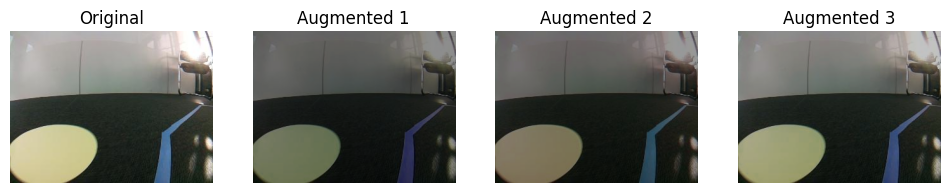

In [13]:
# Sehen wir uns an, was die Augmentation mit dem Bild macht
# (da die Transformation zufällig ist, kannst du die Zelle mehrmals ausführen um verschiedene Ergebnisse zu sehen)

# Wir verwenden unser Beispiel-Bild von weiter oben
fig, axs = plt.subplots(1, 4, figsize=(3*4, 3))
for i, ax in enumerate(axs):
    # Zuerst das Originalbild
    if i == 0:
        ax.imshow(img)
        ax.set_title("Original")
        ax.axis('off')
        continue
    # Danach 3 zusätzlich augmentierte Bilder
    else:
        augmented_img = transformer(img)
        ax.imshow(augmented_img)
        ax.set_title(f"Augmented {i}")
        ax.axis('off')



Unser Transformer werden wir anschliessend in im Trainings-Datenset einbauen.

### Datasets und Datenloader erstellen

In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import pil_to_tensor

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path)
        # Wir werden das Bild etwas verkleinern, um Rechenzeit zu sparen (es sind immer noch genügend Informationen im Bild vorhanden)
        # Original ist das Bild BxH 320x240 Pixel gross, wir verkleinern es auf 16x120 Pixel
        image = image.resize((160, 120), resample=Image.Resampling.NEAREST)
        # Augmentation (wenn vorhanden)
        if self.transform:
            image = self.transform(image)
        image_tensor = pil_to_tensor(image)
        image_tensor = image_tensor / 255.0  # Normalization
        angle, _ = read_data_from_json(path)
        angle_tensor = torch.tensor(angle, dtype=torch.float32).unsqueeze(0)
        return image_tensor, angle_tensor

In [15]:
import random

# Wir werden 80% der Daten für das Training verwenden und 20% für das Validieren
random.shuffle(image_paths)
split_idx = int(len(image_paths) * 0.8)
train_image_paths = image_paths[:split_idx]
val_image_paths = image_paths[split_idx:]

# Wichtig: Augmentation nur für das Trainingsset aktivieren!
train_dataset = ImageDataset(train_image_paths, transform=transformer)
val_dataset = ImageDataset(val_image_paths, transform=None)

# Überprüfen wir mal die Grösse dieser Sets
print(len(train_dataset), len(val_dataset))

# Inhalt anschauen
image, angle = train_dataset[0]
print(image.shape, image.dtype, angle, angle.dtype)

10346 2587
torch.Size([3, 120, 160]) torch.float32 tensor([-24.9919]) torch.float32


In [16]:
# Erstellen der DataLoaders
BATCH_SIZE = 128
training_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8
)
validation_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
 
)
 
# Ein Batch aus dem DataLoader laden und dessen Shape anzeigen
images, labels = next(iter(training_loader))
print(f"Input shape: {images.shape}")
print(f"Output shape {labels.shape}")

Input shape: torch.Size([128, 3, 120, 160])
Output shape torch.Size([128, 1])


## Model definieren & trainieren

Vor dem Training erstellen wir einen Ordner in den wir das Modell sowie die Auswertung speichern können:

In [17]:
run_directory = create_run_dir('../runs/drive/')

### Model definieren

Fürs Erste werden wir ein Neuronale Netzwerk vorgeben. Es besteht aus mehreren Schichten Convolutional Layers am Anfang und einem Dense Neuronal Netzwerk danach.

(Du darfst das Netzwerk anpassen wenn du willst. Für den Anfang empfehlen wir aber mit dieser Architektur zu arbeiten.)

In [18]:
class DriveModel(nn.Module):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr

        self.layers = nn.Sequential(
            OrderedDict(
                conv1 = nn.Conv2d(3, 18, 5, stride=2, padding=1),
                batch1 = nn.BatchNorm2d(18),
                relu1 = nn.ReLU(),

                conv2 = nn.Conv2d(18, 32, 5, stride=2, padding=1),
                batch2 = nn.BatchNorm2d(32),
                relu2 = nn.ReLU(),

                conv3 = nn.Conv2d(32, 64, 5, stride=2, padding=1),
                batch3 = nn.BatchNorm2d(64),
                relu3 = nn.ReLU(),

                conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1),
                batch4 = nn.BatchNorm2d(128),
                relu4 = nn.ReLU(),

                conv5 = nn.Conv2d(128, 64, 3, stride=1, padding=1),
                batch5 = nn.BatchNorm2d(64),
                relu5 = nn.ReLU(),

                one2one = nn.Conv2d(64, 1, 1, stride=1),

                flatten = nn.Flatten(1, -1),
                linear1 = nn.Linear(266, 16, bias=True),
                linear2 = nn.Linear(16, 1, bias=True),
            )
        )

    def forward(self, x):
        return self.layers(x)


Um das Training zu vereinfachen, laden wir unser Pytorch Modell als Pytorch Lightning Modell. Zusätzlich erstellen wir einen Logger welche den Loss während dem Training als Python Dictionary speichert.

In [19]:
model = DriveModel()
lightning_model = LightningDriveModel(model)

logger = DictLogger()

Wir können uns die Architektur des Modells anschauen.
Hier sieht man die einzelnen Schichten (Layers), welche Ausgangssignale (Output Shape) sie erzeugen, sowie die Anzahl künstlicher Neuronen (Parameter), welche sie enthalten.

In [20]:
ModelSummary().on_fit_start(Trainer(), lightning_model)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | DriveModel | 219 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.879     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


### Trainieren

Für das Training fehlen uns jetzt nur noch die Hyperparameter:
- Epochs = Wie viel mal das Modell mit dem ganzen Datensatz trainiert
- Learning Rate = Wie stark sich das Modell während dem Training anpasst

In [21]:
# Hyperparameter definieren
EPOCHS = 50
LEARNING_RATE = 0.005

lightning_model.lr = LEARNING_RATE

# Trainer initialisieren.
trainer = Trainer(max_epochs=EPOCHS, callbacks=[logger])

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [22]:
%%time
# Die Zeile oben Zeile sorgt dafür, dass unten angezeigt wird, wie lange es gedauert hat, diese Notebook Zelle auszuführen.

torch.set_float32_matmul_precision('medium')  # Beschleunigt das Training auf Kosten leicht geringerer Präzision

# Das Training starten. Dieses dauert eine Weile...
trainer.fit(lightning_model, training_loader, validation_loader


)

/home/fabian/projects/ai-challange/.venv/lib64/python3.13/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | DriveModel | 219 K  | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
219 K     Trainable params
0         Non-traina

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 41 s, sys: 33.2 s, total: 1min 14s
Wall time: 2min


Hinweis: Falls der Fehler `Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm)` auftritt, musst du die BATCH_SIZE reduzieren.

### Training anzeigen

### 📝 Aufgabe 3.3
Um das Training beurteilen zu können müssen wir die geloggten Metriken auswerten. In `logger.metrics` sind für jede Epoche der Validation Loss, und der Trainings Loss gespeichert. Plotte die Metriken mit Matplotlib und vergiss nicht den Plot in der run directory zu speichern.

*Tipp: Es kann sein, dass nicht alle Metriken in allen Epochen geloggt werden.*

Available metrics keys:
Number of metric dictionaries: 51
Metric dict 0 keys: ['val_loss']
Metric dict 1 keys: ['val_loss']
Metric dict 2 keys: ['val_loss', 'train_loss']


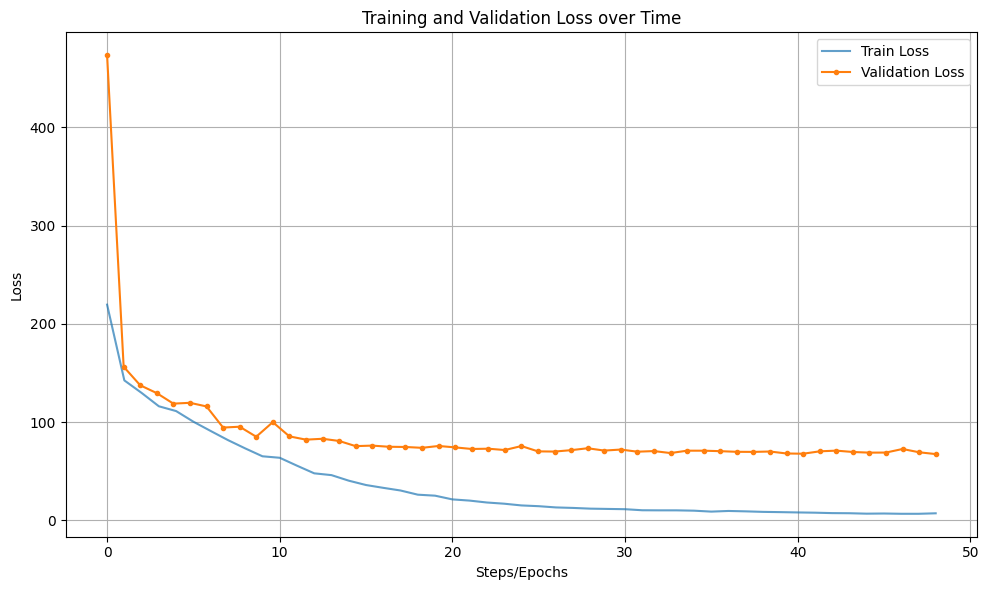

In [23]:
def plot_training(metrics: list[dict[str, list[float]]], save_to: str | Path = None):
    # 📝 Aufgabe: Plotte die Metriken
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
    
    # Extract the metrics data
    train_losses = []
    val_losses = []
    
    for metric_dict in metrics:
        # Handle train loss
        if 'train_loss_step' in metric_dict:
            loss_value = metric_dict['train_loss_step']
            if hasattr(loss_value, 'item'):  # It's a tensor
                train_losses.append(loss_value.item())
            elif isinstance(loss_value, (list, tuple)):
                train_losses.extend([x.item() if hasattr(x, 'item') else x for x in loss_value])
            else:
                train_losses.append(float(loss_value))
                
        elif 'train_loss' in metric_dict:
            loss_value = metric_dict['train_loss']
            if hasattr(loss_value, 'item'):  # It's a tensor
                train_losses.append(loss_value.item())
            elif isinstance(loss_value, (list, tuple)):
                train_losses.extend([x.item() if hasattr(x, 'item') else x for x in loss_value])
            else:
                train_losses.append(float(loss_value))
            
        # Handle validation loss
        if 'val_loss' in metric_dict:
            loss_value = metric_dict['val_loss']
            if hasattr(loss_value, 'item'):  # It's a tensor
                val_losses.append(loss_value.item())
            elif isinstance(loss_value, (list, tuple)):
                val_losses.extend([x.item() if hasattr(x, 'item') else x for x in loss_value])
            else:
                val_losses.append(float(loss_value))
    
    # Plot the losses
    if train_losses:
        ax1.plot(train_losses, label='Train Loss', alpha=0.7)
    if val_losses:
        # Validation loss is typically logged less frequently, so we need to spread it out
        val_epochs = np.linspace(0, len(train_losses)-1, len(val_losses)) if train_losses else range(len(val_losses))
        ax1.plot(val_epochs, val_losses, label='Validation Loss', marker='o', markersize=3)
    
    ax1.set_title('Training and Validation Loss over Time')
    ax1.set_xlabel('Steps/Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    plt.tight_layout()
    
    # Save the plot if save_to is provided
    if save_to:
        plt.savefig(Path(save_to) / 'training_metrics.png', dpi=150, bbox_inches='tight')
    
    plt.show()

# First, let's examine what's actually in the logger metrics
print("Available metrics keys:")
if logger.metrics:
    print(f"Number of metric dictionaries: {len(logger.metrics)}")
    for i, metric_dict in enumerate(logger.metrics[:3]):  # Show first 3 for inspection
        print(f"Metric dict {i} keys: {list(metric_dict.keys())}")

plot_training(logger.metrics, save_to=run_directory)

Mit der folgenden Funktion können wir unserem Modell ein Bild geben den Winkel erhalten:

In [24]:
def predict(img_tensor):
    model.eval()
    with torch.no_grad():
        y_pred = model(img_tensor.unsqueeze(0))
    return y_pred.item()

# Testen wir unsere Funktion
image_tensor, _ = train_dataset[0]
angle_pred = predict(image_tensor)
print(f"Predicted angle: {angle_pred}")

Predicted angle: -24.80499267578125


## Validierung
Die Trainingsmetriken zeigen uns schon auf wie gut unser Training geklappt hat. Um einen noch besseren Einblick zu bekommen, wie gut das trainierte Modell tatsächlich ist, können wir verschiedene Methoden anwenden um unser Modell zu testen.

### 📝 Aufgabe 3.4
Als erstes wollen wir den totalen Fehler über das ganze Test-Set berechnen. Schreibe eine Funktion, welche:
1. ein datenset entgegen nimmt,
2. über das datenset iteriert und für jedes Bild eine Prediction macht (nutze die `predict` funktion von oben)
3. für jede Prediction den Fehler ausrechnet (`y_pred` - `y_true`)
4. die Fehler zusammenzählen
5. den total Fehler durch die Anzahl Bilder teilt um den Durchschnittlichen Fehler zu bekommen
6. den Fehler zurückgibt und ihn als text file in `save_to` speichert.

In [25]:
def calculate_error(data: Dataset, save_to: str | Path = None) -> float:
    # 📝 Vervollständige die funktion:
    true_y = [angle.item() for _, angle in data]
    pred_y = [predict(img) for img, _ in data]
    errors = [abs(t - p) for t, p in zip(true_y, pred_y)]
    mean_error = sum(errors) / len(errors)
    #6. den Fehler zurückgibt und ihn als text file in `save_to` speichert.
    if save_to is not None:
        save_path = Path(save_to) / 'mean_error.txt'
        with open(save_path, 'w') as f:
            f.write(f"{mean_error:.4f}\n")
        
    return mean_error


error = calculate_error(val_dataset, save_to=run_directory)
print(f"Der durchschnittliche Fehler auf dem Validierung-Set ist {error:.1f}")

Der durchschnittliche Fehler auf dem Validierung-Set ist 6.2


Was sagt uns diese Zahl? Wie gross im Durchschnitt der Winkel-Fehler ist. Eigentlich müssen wir aber nur eins wissen: Je geringer, desto besser unser Modell! Der Fehler hilft uns also vor allem verschiedenen Modelle zu vergleichen.

Wir können aber auch visuell überprüfen, ob das Modell die Kurven korrekt vorhersagt und bei welchen Werten es Mühe hat. Dazu sortieren wir zuerst das Datenset der Grösse nach. Wenn das Modell gut ist sollten die Linien übereinander liegen.

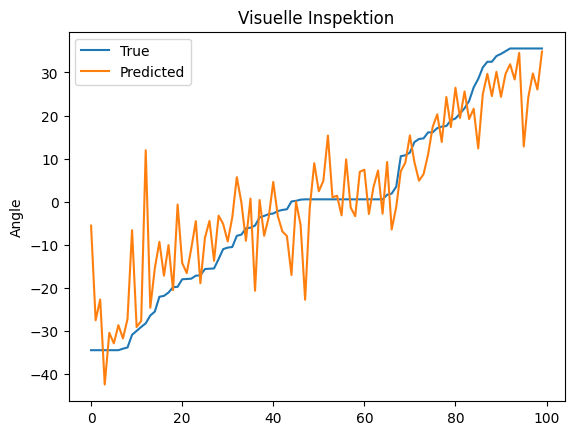

In [26]:
def visualize_angels(data: Dataset):
    true_y = [angle.item() for _, angle in data]

    n = min(100, len(true_y))
    true_y_plot = true_y[:n]
    pred_y_plot = [predict(image_tensor) for image_tensor, _ in val_dataset][:n]
    sorted_idx = np.argsort(true_y_plot)
    true_y_plot = np.array(true_y_plot)[sorted_idx]
    pred_y_plot = np.array(pred_y_plot)[sorted_idx]

    plt.plot(true_y_plot, label="True")
    plt.plot(pred_y_plot, label="Predicted")
    plt.legend()
    plt.ylabel("Angle")
    plt.title("Visuelle Inspektion")

visualize_angels(val_dataset)

Als letzte Analyse wollen wir noch einige Bilder manuell inspizieren. Dazu brauchen wir eine Funktion die einige zufällige Bilder aus einem Datenset auswählt, durch das Modell laufen lässt und danach das Resultat darstellt.

### 📝 Aufgabe 3.5
Schreibe eine Funktion die
1. als Argument ein Dataloader und ein `save_to` Pfad entgegen nimmt
2. aus dem Dataloader 6 zufällige Bilder auswählt und in einer Liste speichert
3. zu jedem ausgewählten Bild den echten Wert für den Winkel in einer zweiten Liste speichert
4. zu jedem Bild mit der `predict` Funktion eine prediction macht und in einer dritten Liste speichert
5. die Bilder zusammen mit `True`, `Pred` und `Fehler` plottet
6. den Plot anzeigt und in der `save_to` directory als png speichert.

Plot saved to: ../runs/drive/run_001/drive_predictions_visualization.png


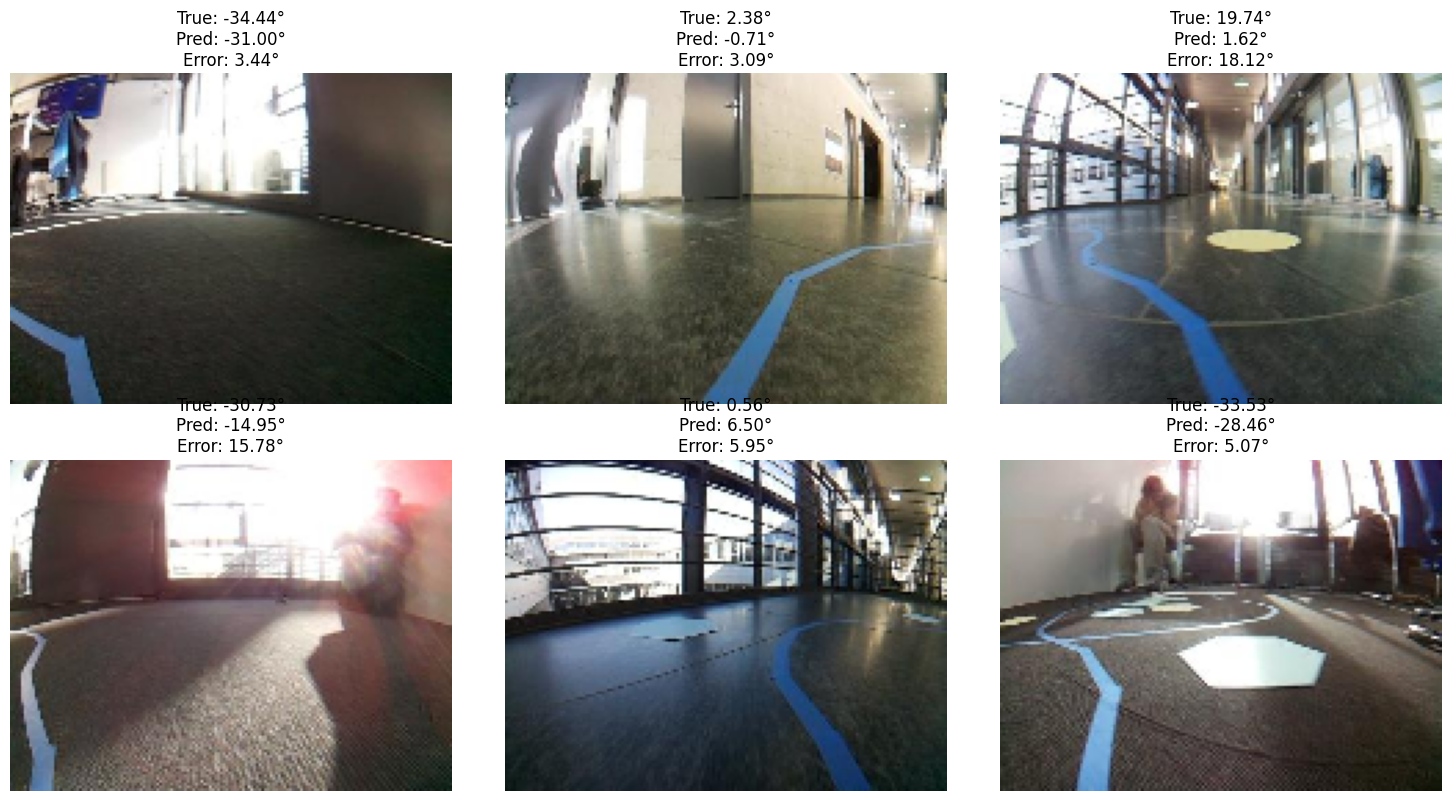

In [27]:
def visualize_drive_predictions(dataloader: DataLoader, save_to: str | Path = None):
    # 📝 Vervollständige die funktion:
    # 1. Select 6 random images from the dataloader
    dataset = dataloader if hasattr(dataloader, '__len__') else dataloader.dataset
    n_samples = min(6, len(dataset))
    
    # Randomly select indices
    random_indices = random.sample(range(len(dataset)), n_samples)
    
    # 2. Store images and true angles
    images = []
    true_angles = []
    
    for idx in random_indices:
        image_tensor, angle_tensor = dataset[idx]
        images.append(image_tensor)
        true_angles.append(angle_tensor.item())
    
    # 4. Make predictions for each image
    predicted_angles = []
    for image_tensor in images:
        pred_angle = predict(image_tensor)
        predicted_angles.append(pred_angle)
    
    # 5. Plot the images with True, Pred, and Error values
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(n_samples):
        # Convert tensor to displayable format
        img_display = images[i].permute(1, 2, 0).numpy()
        
        true_angle = true_angles[i]
        pred_angle = predicted_angles[i]
        error = abs(true_angle - pred_angle)
        
        axes[i].imshow(img_display)
        axes[i].set_title(f'True: {true_angle:.2f}°\nPred: {pred_angle:.2f}°\nError: {error:.2f}°')
        axes[i].axis('off')
    
    plt.tight_layout()
    
    # 6. Save the plot if save_to is provided
    if save_to:
        save_path = Path(save_to) / 'drive_predictions_visualization.png'
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()


visualize_drive_predictions(val_dataset, save_to=run_directory)

## Modell Export

Damit wir unser Modell auf dem Auto laufen lassen können, müssen wir es exportieren.

Dazu speichern wir es im ONNX-Format. Dieses Format komprimiert und optimiert das Model, damit es so schnell wie möglich auf dem Auto läuft (fps). Die export funktion benötigt ein Beispiel Input um die "shape" zu speichern.

In [28]:
# Definieren, wo das Model gespeichert werden soll. Erstelle den Ordner, falls er noch nicht existiert.

model_path = Path(f'../models/drive/{run_directory.name}/DriveModel_v1.onnx')

# Zur Sicherheit prüfen, ob das Model bereits existiert, (lösche es, wenn du es überschreiben willst. Oder benenne es um)
assert not model_path.exists(), 'Das Model existiert bereits'
model_path.parent.mkdir(parents=True, exist_ok=True)

# Model speichern
example_input = train_dataset[0][0].unsqueeze(0)
torch.onnx.export(
    model.to('cpu'),
    example_input,
    model_path,
)

[torch.onnx] Obtain model graph for `DriveModel([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `DriveModel([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 5 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 20},
            producer_name='pytorch',
            producer_version='2.9.0+cu128',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"x"<FLOAT,[1,3,120,160]>
            ),
            outputs=(
                %"linear_1"<FLOAT,[1,1]>
            ),
            initializers=(
                %"layers.conv1.weight"<FLOAT,[18,3,5,5]>{Tensor(...)},
                %"layers.conv1.bias"<FLOAT,[18]>{Tensor(...)},
                %"layers.conv2.weight"<FLOAT,[32,18,5,5]>{Tensor(...)},
                %"layers.conv2.bias"<FLOAT,[32]>{Tensor(...)},
                %"layers.conv3.weight"<FLOAT,[64,32,5,5]>{Tensor(...)},
                %"layers.conv3.bias"<FLOAT,[64]>{Tensor(...)},
                %"layers.conv4.weight"<FLOAT,[128,64,3,3]>{Tensor(...)},
                %"layers.conv4.bias"<FLOAT,[128]>{T